In [371]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import statsmodels.formula.api as smf
from patsy import dmatrix

import causalpy as cp

In [310]:
N = 1000


def inv_logit(x):
    return 1 / (1 + np.exp(-x))


df1 = pd.DataFrame(
    np.random.multivariate_normal([0.5, 1], [[2, 1], [1, 1]], size=N),
    columns=["x1", "x2"],
)
df1["trt"] = np.where(
    -0.5 + 0.25 * df1["x1"] + 0.75 * df1["x2"] + np.random.normal(0, 1, size=N) > 0,
    1,
    0,
)
TREATMENT_EFFECT = 2
df1["outcome"] = (
    4
    + TREATMENT_EFFECT * df1["trt"]
    + df1["x1"]
    + df1["x2"]
    + np.random.normal(0, 1, size=N)
)
df1.head()

,x1,x2,trt,outcome
0,2.238452,2.060227,1,10.022882
1,0.739961,0.926924,0,4.978688
2,1.191126,-0.532201,0,4.805062
3,-1.487591,0.373743,0,1.449932
4,-0.256297,1.680710,1,9.100173


/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/pymc/data.py:436: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


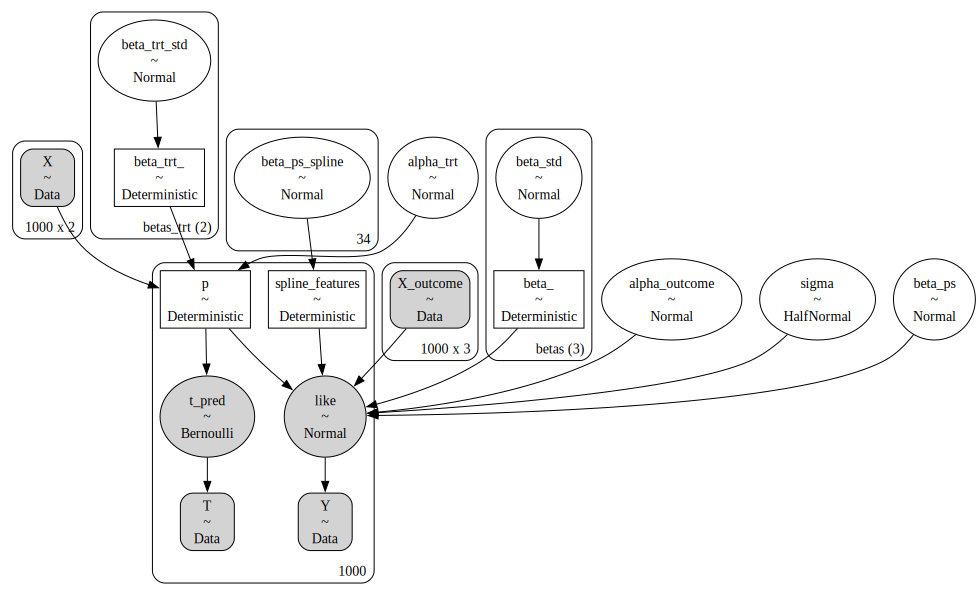

In [311]:
coords = {
    "betas": ["trt", "x1", "x2"],
    "betas_trt": ["x1", "x2"],
    "obs": range(df1.shape[0]),
}

N = df1.shape[0]
X_trt = df1[["x1", "x2"]].values
X_outcome = df1[["trt", "x1", "x2"]].values
T_data = df1["trt"].values
Y_data = df1["outcome"].values


def make_model(
    X_trt,
    X_outcome,
    T_data,
    Y_data,
    coords,
    priors={
        "beta_": [0, 1],
        "beta_trt": [0, 1],
        "alpha_trt": [0, 1],
        "alpha_outcome": [0, 1],
    },
    noncentred=True,
):
    with pm.Model(coords=coords) as model:
        X_data_trt = pm.Data("X", X_trt)
        X_data_outcome = pm.Data("X_outcome", X_outcome)
        T_data_ = pm.Data("T", T_data, mutable=True)
        Y_data_ = pm.Data("Y", Y_data)

        if noncentred:
            mu_beta_trt, sigma_beta_trt = priors["beta_trt"]
            beta_trt_std = pm.Normal("beta_trt_std", 0, 1, dims="betas_trt")
            beta_trt = pm.Deterministic(
                "beta_trt_",
                mu_beta_trt + sigma_beta_trt * beta_trt_std,
                dims="betas_trt",
            )

            mu_beta, sigma_beta = priors["beta_"]
            beta_std = pm.Normal("beta_std", 0, 1, dims="betas")
            beta = pm.Deterministic(
                "beta_", mu_beta + sigma_beta * beta_std, dims="betas"
            )
        else:
            beta_trt = pm.Normal(
                "beta_trt_",
                priors["beta_trt"][0],
                priors["beta_trt"][1],
                dims="betas_trt",
            )

            beta = pm.Normal(
                "beta_", priors["beta_"][0], priors["beta_"][1], dims="betas"
            )

        beta_ps_spline = pm.Normal("beta_ps_spline", 0, 1, size=34)
        beta_ps = pm.Normal("beta_ps", 0, 1)

        alpha_trt = pm.Normal(
            "alpha_trt", priors["alpha_trt"][0], priors["alpha_trt"][1]
        )
        mu_trt = alpha_trt + pm.math.dot(X_data_trt, beta_trt)
        p = pm.Deterministic("p", pm.math.invlogit(mu_trt))

        pm.Bernoulli("t_pred", p=p, observed=T_data_)

        B = dmatrix(
            "bs(ps, knots=knots, degree=3, include_intercept=True) - 1",
            {"ps": np.linspace(0, 1, X_trt.shape[0]), "knots": np.linspace(0, 1, 30)},
        )
        B_f = np.asarray(B, order="F")
        splines_summed = pm.Deterministic(
            "spline_features", pm.math.dot(B_f, beta_ps_spline.T)
        )

        alpha_outcome = pm.Normal(
            "alpha_outcome", priors["alpha_outcome"][0], priors["alpha_outcome"][1]
        )
        mu_outcome = (
            alpha_outcome
            + pm.math.dot(X_data_outcome, beta)
            + p * splines_summed
            + beta_ps * p
        )
        sigma = pm.HalfNormal("sigma", 1)

        _ = pm.Normal("like", mu_outcome, sigma, observed=Y_data_)

    return model


model = make_model(X_trt, X_outcome, T_data, Y_data, coords)

pm.model_to_graphviz(model)

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/pymc/data.py:436: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


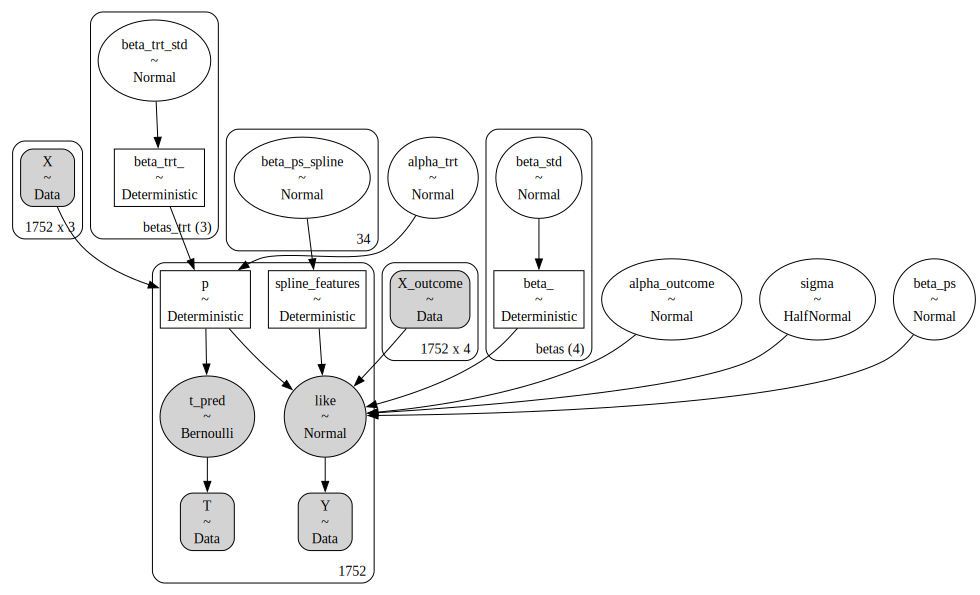

In [ ]:
def make_treatment_model(
    X_trt,
    T_data,
    coords,
    priors={
        "beta_": [0, 1],
        "beta_trt": [0, 1],
        "alpha_trt": [0, 1],
        "alpha_outcome": [0, 1],
    },
    noncentred=True,
):
    with pm.Model(coords=coords) as model_trt:
        X_data_trt = pm.Data("X", X_trt)
        T_data_ = pm.Data("T", T_data, mutable=True)

        if noncentred:
            mu_beta_trt, sigma_beta_trt = priors["beta_trt"]
            beta_trt_std = pm.Normal("beta_trt_std", 0, 1, dims="betas_trt")
            beta_trt = pm.Deterministic(
                "beta_trt_",
                mu_beta_trt + sigma_beta_trt * beta_trt_std,
                dims="betas_trt",
            )

        else:
            beta_trt = pm.Normal(
                "beta_trt_",
                priors["beta_trt"][0],
                priors["beta_trt"][1],
                dims="betas_trt",
            )

        alpha_trt = pm.Normal(
            "alpha_trt", priors["alpha_trt"][0], priors["alpha_trt"][1]
        )
        mu_trt = alpha_trt + pm.math.dot(X_data_trt, beta_trt)
        p = pm.Deterministic("p", pm.math.invlogit(mu_trt))

        pm.Bernoulli("t_pred", p=p, observed=T_data_)
    return model_trt


def make_outcome_model(
    X_outcome,
    Y_data,
    coords,
    priors={
        "beta_": [0, 1],
        "beta_trt": [0, 1],
        "alpha_trt": [0, 1],
        "alpha_outcome": [0, 1],
    },
    noncentred=True,
    propensity_score_idata=None,
):
    propensity_scores = az.extract(propensity_score_idata)["p"]
    with pm.Model(coords=coords) as model_outcome:
        X_data_outcome = pm.Data("X_outcome", X_outcome)
        Y_data_ = pm.Data("Y", Y_data)

        if noncentred:
            mu_beta, sigma_beta = priors["beta_"]
            beta_std = pm.Normal("beta_std", 0, 1, dims="betas")
            beta = pm.Deterministic(
                "beta_", mu_beta + sigma_beta * beta_std, dims="betas"
            )
        else:
            beta = pm.Normal(
                "beta_", priors["beta_"][0], priors["beta_"][1], dims="betas"
            )

        beta_ps_spline = pm.Normal("beta_ps_spline", 0, 1, size=34)

        chosen = np.random.choice(range(propensity_scores.shape[1]))
        p = propensity_scores[:, chosen].values

        B = dmatrix(
            "bs(ps, knots=knots, degree=3, include_intercept=True, lower_bound=0, upper_bound=1) - 1",
            {"ps": p, "knots": np.linspace(0, 1, 30)},
        )
        B_f = np.asarray(B, order="F")
        splines_summed = pm.Deterministic(
            "spline_features", pm.math.dot(B_f, beta_ps_spline.T)
        )

        alpha_outcome = pm.Normal(
            "alpha_outcome", priors["alpha_outcome"][0], priors["alpha_outcome"][1]
        )
        mu_outcome = alpha_outcome + pm.math.dot(X_data_outcome, beta) + splines_summed
        sigma = pm.HalfNormal("sigma", 1)

        _ = pm.Normal("like", mu_outcome, sigma, observed=Y_data_)

    return model_outcome


def make_2step_model(X_trt, X_outcome, T_data, Y_data, coords, priors):
    treatment_model = make_treatment_model(X_trt, T_data, coords, priors)
    with treatment_model:
        idata_treatment = pm.sample_prior_predictive()
        idata_treatment.extend(pm.sample())

    outcome_model = make_outcome_model(
        X_outcome, Y_data, coords, priors, propensity_score_idata=idata_treatment
    )
    with outcome_model:
        idata_outcome = pm.sample_prior_predictive()
        idata_outcome.extend(pm.sample())

    return idata_treatment, idata_outcome, treatment_model, outcome_model


model = make_model(X_trt, X_outcome, T_data, Y_data, coords)

pm.model_to_graphviz(model)

## Running Seperate Models

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/pymc/data.py:436: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


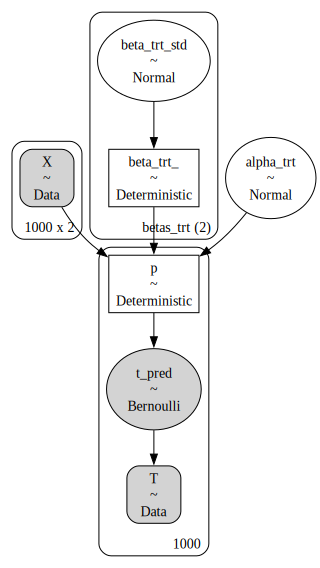

In [313]:
model_treatment = make_treatment_model(X_trt, T_data, coords)

pm.model_to_graphviz(model_treatment)

In [314]:
with model_treatment:
    idata_treatment = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, alpha_trt]
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


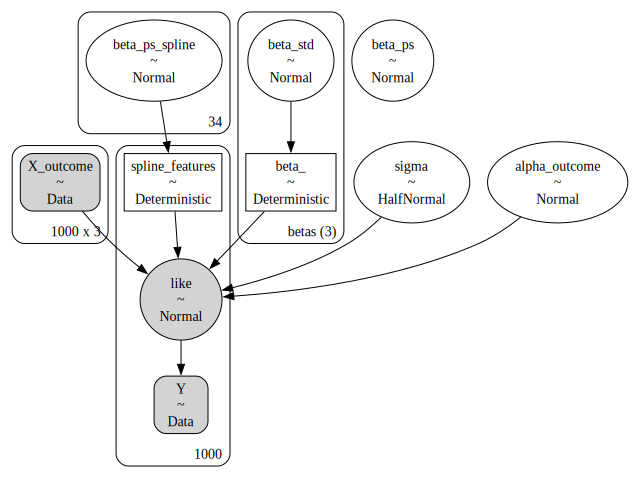

In [315]:
model_outcome = make_outcome_model(
    X_outcome, Y_data, coords, propensity_score_idata=idata_treatment
)
pm.model_to_graphviz(model_outcome)

In [316]:
with model_outcome:
    idata_outcome = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_std, beta_ps_spline, beta_ps, alpha_outcome, sigma]
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [317]:
az.summary(idata_outcome, var_names=["beta_"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_[trt],1.980,0.079,1.831,2.123,0.001,0.001,6790.0,3176.0,1.0
beta_[x1],0.974,0.049,0.879,1.060,0.001,0.001,2177.0,2267.0,1.0
beta_[x2],1.016,0.116,0.780,1.224,0.003,0.002,1661.0,2262.0,1.0


## Running Joint Distribution Models

In [246]:
with model:
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(tune=2000, target_accept=0.95, nuts_sampler="numpyro"))

Sampling: [alpha_outcome, alpha_trt, beta_ps, beta_ps_spline, beta_std, beta_trt_std, like, sigma, t_pred]


  0%|          | 0/3000 [00:01<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [247]:
az.summary(
    idata, var_names=["alpha_trt", "beta_trt_", "alpha_outcome", "beta_", "beta_ps"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_trt,-1.075,0.131,-1.327,-0.840,0.002,0.002,3854.0,2994.0,1.0
beta_trt_[x1],0.520,0.081,0.368,0.670,0.001,0.001,4838.0,3289.0,1.0
beta_trt_[x2],1.324,0.133,1.069,1.569,0.002,0.002,3312.0,2772.0,1.0
alpha_outcome,4.225,0.126,3.996,4.470,0.003,0.002,2476.0,2470.0,1.0
beta_[trt],1.822,0.084,1.671,1.985,0.001,0.001,5440.0,3120.0,1.0
beta_[x1],1.090,0.044,1.009,1.171,0.001,0.001,3610.0,3085.0,1.0
beta_[x2],0.971,0.083,0.820,1.129,0.001,0.001,3130.0,3196.0,1.0
beta_ps,-0.187,0.385,-0.906,0.523,0.008,0.006,2247.0,2436.0,1.0


In [194]:
X_outcome_trt = X_outcome.copy()
X_outcome_trt[:, 0] = 1

X_outcome_ntrt = X_outcome.copy()
X_outcome_ntrt[:, 0] = 0

In [195]:
with pm.do(
    model,
    {"T": np.ones(len(df1), dtype=np.int32), "X_outcome": X_outcome_trt},
    prune_vars=True,
) as treatment_model:
    idata_trt = pm.sample_posterior_predictive(idata, var_names=["like", "p"])

with pm.do(
    model,
    {"T": np.zeros(len(df1), dtype=np.int32), "X_outcome": X_outcome_ntrt},
    prune_vars=True,
) as ntreatment_model:
    idata_ntrt = pm.sample_posterior_predictive(idata, var_names=["like", "p"])

Sampling: [like]


Output()

Sampling: [like]


Output()

In [196]:
idata_trt["posterior_predictive"]["like"].mean()

<xarray.DataArray 'like' ()> Size: 8B
array(7.38106334)

In [197]:
idata_ntrt["posterior_predictive"]["like"].mean()

<xarray.DataArray 'like' ()> Size: 8B
array(5.41605235)

In [198]:
(
    idata_trt["posterior_predictive"]["like"].mean()
    - idata_ntrt["posterior_predictive"]["like"].mean()
)

<xarray.DataArray 'like' ()> Size: 8B
array(1.96501099)

## Nets Example



In [346]:
nets_df = pd.read_csv("../../../causalpy/data/nets_df.csv")
nets_df["trt"] = nets_df["net_num"]
nets_df["outcome"] = nets_df["malaria_risk"]
nets_df

,id,net,net_num,malaria_risk,income,health,household,eligible,temperature,resistance,trt,outcome
0,1,True,1,33,781,56,2,False,21.1,59,1,33
1,2,False,0,42,974,57,4,False,26.5,73,0,42
2,3,False,0,80,502,15,3,False,25.6,65,0,80
3,4,True,1,34,671,20,5,True,21.3,46,1,34
4,5,False,0,44,728,17,5,False,19.2,54,0,44
...,...,...,...,...,...,...,...,...,...,...,...,...
1747,1748,True,1,18,961,27,4,False,22.1,27,1,18
1748,1749,False,0,49,906,49,5,False,30.7,55,0,49
1749,1750,False,0,17,1325,92,2,False,21.4,52,0,17
1750,1751,False,0,46,879,33,6,False,27.4,62,0,46


In [347]:
coords = {
    "betas": ["trt", "income", "temperature", "health"],
    "betas_trt": ["income", "temperature", "health"],
    "obs": range(nets_df.shape[0]),
}

N = nets_df.shape[0]
X_trt = nets_df[["income", "temperature", "health"]].values
X_trt = (X_trt - X_trt.mean(axis=0)) / X_trt.std(axis=0)
X_outcome = nets_df[["trt", "income", "temperature", "health"]].values
X_outcome = (X_outcome - X_outcome.mean(axis=0)) / X_outcome.std(axis=0)
T_data = nets_df["trt"].values
X_outcome[:, 0] = T_data
Y_data = nets_df["outcome"].values

priors = {
    "beta_": [0, 1],
    "beta_trt": [0, 1],
    "alpha_trt": [0, 1],
    "alpha_outcome": [40, 30],
}
net_model = make_model(X_trt, X_outcome, T_data, Y_data, coords, priors=priors)

with net_model:
    idata_net = pm.sample(tune=2000, target_accept=0.98)

idata_treatment_2s_net, idata_outcome_2s_net, treatment_model_net, outcome_model_net = (
    make_2step_model(X_trt, X_outcome, T_data, Y_data, coords, priors=priors)
)

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/pymc/data.py:436: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, beta_std, beta_ps_spline, beta_ps, alpha_trt, alpha_outcome, sigma]
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 25 seconds.
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/pymc/data.py:436: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha_trt, beta_trt_std, t_pred]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, alpha_trt]
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [alpha_outcome, beta_ps, beta_ps_spline, beta_std, like, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_std, beta_ps_spline, beta_ps, alpha_outcome, sigma]
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

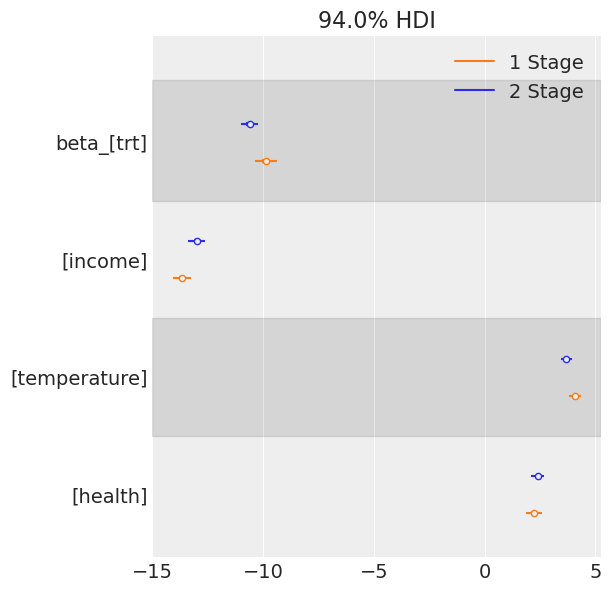

In [349]:
az.plot_forest(
    [idata_outcome_2s_net, idata_net],
    var_names=["beta_"],
    model_names=["2 Stage", "1 Stage"],
    combined=True,
)

In [348]:
compare_estimate = pd.concat(
    {
        "1-stage-model": az.summary(
            idata_net, var_names=["alpha_trt", "beta_", "beta_ps", "alpha_outcome"]
        ),
        "2-stage-model": az.summary(
            idata_outcome_2s_net, var_names=["beta_", "beta_ps", "alpha_outcome"]
        ),
    }
)
compare_estimate

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
1-stage-model alpha_trt           -0.483  0.052  -0.582   -0.391      0.001   
              beta_[trt]          -9.858  0.257 -10.346   -9.393      0.004   
              beta_[income]      -13.665  0.213 -14.080  -13.279      0.004   
              beta_[temperature]   4.096  0.139   3.818    4.345      0.002   
              beta_[health]        2.210  0.192   1.853    2.577      0.003   
              beta_ps              0.117  1.048  -1.791    2.195      0.024   
              alpha_outcome       39.379  0.444  38.574   40.239      0.010   
2-stage-model beta_[trt]         -10.615  0.208 -10.994  -10.230      0.002   
              beta_[income]      -12.977  0.206 -13.383  -12.620      0.003   
              beta_[temperature]   3.685  0.127   3.457    3.927      0.002   
              beta_[health]        2.399  0.152   2.112    2.676      0.002   
              beta_ps             -0.005  0.992  -1.830    1.840      0.011   
              alpha_outcome       41.782  0.298  41.211   42.337      0.005   

                                  mcse_sd  ess_bulk  ess_tail  r_hat  
1-stage-model alpha_trt             0.001    4770.0    3146.0    1.0  
              beta_[trt]            0.003    4654.0    3105.0    1.0  
              beta_[income]         0.003    2446.0    2938.0    1.0  
              beta_[temperature]    0.002    3299.0    2774.0    1.0  
              beta_[health]         0.002    3634.0    3142.0    1.0  
              beta_ps               0.017    1967.0    2576.0    1.0  
              alpha_outcome         0.007    2001.0    2518.0    1.0  
2-stage-model beta_[trt]            0.002    7854.0    2793.0    1.0  
              beta_[income]         0.002    4387.0    2910.0    1.0  
              beta_[temperature]    0.001    4956.0    3533.0    1.0  
              beta_[health]         0.001    7140.0    2816.0    1.0  
              beta_ps               0.016    8128.0    3041.0    1.0  
              alpha_outcome         0.004    3491.0    2616.0    1.0

## LaLonde Example

In [350]:
lalonde = pd.read_csv(
    "https://vincentarelbundock.github.io/Rdatasets/csv/MatchIt/lalonde.csv"
)
lalonde[["hispan", "white"]] = pd.get_dummies(lalonde["race"], drop_first=True)
lalonde.dropna(inplace=True)

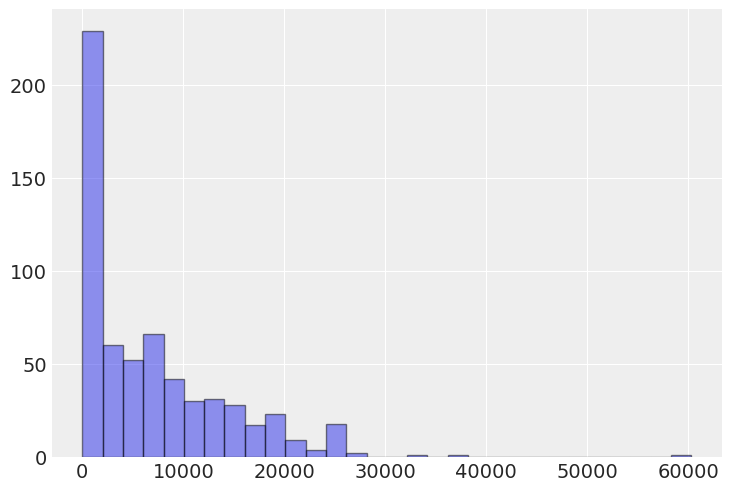

In [351]:
from matplotlib import pyplot as plt

plt.hist(lalonde["re78"], bins=30, alpha=0.5, ec="black");

In [352]:
lalonde.groupby("treat")["re78"].mean()

treat
0    6984.169742
1    6349.143530
Name: re78, dtype: float64

In [361]:
coords = {
    "betas": ["treat", "age", "educ", "hispan", "white", "married", "nodegree"],
    "betas_trt": ["age", "educ", "hispan", "white", "married", "nodegree"],
    "obs": range(lalonde.shape[0]),
}

N = lalonde.shape[0]
X_trt = (
    lalonde[["age", "educ", "hispan", "white", "married", "nodegree"]]
    .astype(np.int32)
    .values
)

X_outcome = (
    lalonde[["treat", "age", "educ", "hispan", "white", "married", "nodegree"]]
    .astype(np.int32)
    .values
)
T_data = lalonde["treat"].values
Y_data = lalonde["re78"].values


priors = {
    "beta_": [0, 4000],
    "beta_trt": [0, 1],
    "alpha_trt": [0, 1],
    "alpha_outcome": [2000, 500],
}

lalonde_model = make_model(
    X_trt, X_outcome, T_data, Y_data, coords, priors, noncentred=False
)

with lalonde_model:
    idata_lalonde = pm.sample(tune=5000, nuts_sampler="numpyro")

(
    idata_treatment_2s_lalonde,
    idata_outcome_2s_lalonde,
    treatment_model_lalonde,
    outcome_model_lalonde,
) = make_2step_model(X_trt, X_outcome, T_data, Y_data, coords, priors=priors)

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/pymc/data.py:436: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/pymc/data.py:436: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha_trt, beta_trt_std, t_pred]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, alpha_trt]
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Sampling: [alpha_outcome, beta_ps, beta_ps_spline, beta_std, like, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_std, beta_ps_spline, beta_ps, alpha_outcome, sigma]
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


In [362]:
compare_estimate = pd.concat(
    {
        "1-stage-model": az.summary(
            idata_lalonde, var_names=["alpha_trt", "beta_", "beta_ps", "alpha_outcome"]
        ),
        "2-stage-model": az.summary(
            idata_outcome_2s_lalonde, var_names=["beta_", "beta_ps", "alpha_outcome"]
        ),
    }
)
compare_estimate

mean       sd    hdi_3%   hdi_97%  \
1-stage-model alpha_trt          -0.778    0.665    -1.957     0.533   
              beta_[treat]     1150.855   46.722  1065.370  1241.935   
              beta_[age]         53.622    1.911    49.972    57.117   
              beta_[educ]       505.376    9.528   488.481   524.327   
              beta_[hispan]    2136.946   62.119  2023.807  2253.300   
              beta_[white]     1518.442   47.207  1433.465  1608.801   
              beta_[married]   2135.800   38.755  2065.817  2210.914   
              beta_[nodegree]  -129.019   51.408  -226.779   -33.858   
              beta_ps             0.012    1.001    -1.830     1.905   
              alpha_outcome   -2002.121  146.600 -2261.369 -1725.481   
2-stage-model beta_[treat]     1150.679   48.381  1057.253  1237.195   
              beta_[age]         53.672    1.960    49.744    57.069   
              beta_[educ]       505.445    9.503   486.808   522.657   
              beta_[hispan]    2138.067   60.286  2023.502  2249.702   
              beta_[white]     1519.274   45.959  1431.339  1603.639   
              beta_[married]   2134.052   39.245  2061.698  2207.319   
              beta_[nodegree]  -128.707   51.636  -229.548   -36.018   
              beta_ps            -0.001    0.970    -1.763     1.827   
              alpha_outcome   -2004.141  144.361 -2280.690 -1747.467   

                               mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat  
1-stage-model alpha_trt            0.012    0.009    2993.0    2796.0    1.0  
              beta_[treat]         0.756    0.536    3830.0    2796.0    1.0  
              beta_[age]           0.027    0.019    5058.0    3064.0    1.0  
              beta_[educ]          0.180    0.128    2792.0    2713.0    1.0  
              beta_[hispan]        1.020    0.722    3713.0    2931.0    1.0  
              beta_[white]         0.788    0.559    3605.0    2730.0    1.0  
              beta_[married]       0.528    0.374    5393.0    3293.0    1.0  
              beta_[nodegree]      0.926    0.655    3081.0    2898.0    1.0  
              beta_ps              0.013    0.016    6257.0    3009.0    1.0  
              alpha_outcome        2.895    2.054    2562.0    2617.0    1.0  
2-stage-model beta_[treat]         0.737    0.522    4327.0    2927.0    1.0  
              beta_[age]           0.027    0.019    5255.0    3146.0    1.0  
              beta_[educ]          0.193    0.137    2424.0    2663.0    1.0  
              beta_[hispan]        0.908    0.644    4418.0    2793.0    1.0  
              beta_[white]         0.747    0.530    3796.0    3442.0    1.0  
              beta_[married]       0.491    0.347    6358.0    3014.0    1.0  
              beta_[nodegree]      0.983    0.704    2762.0    2884.0    1.0  
              beta_ps              0.011    0.017    8043.0    2976.0    1.0  
              alpha_outcome        3.096    2.190    2179.0    2345.0    1.0

In [363]:
X_outcome_trt = X_outcome.copy()
X_outcome_trt[:, 0] = 1
X_outcome_trt = X_outcome_trt.astype(np.int32)

X_outcome_ntrt = X_outcome.copy()
X_outcome_ntrt[:, 0] = 0
X_outcome_ntrt = X_outcome_ntrt.astype(np.int32)


with pm.do(
    lalonde_model,
    {"T": np.ones(len(lalonde), dtype=np.int32), "X_outcome": X_outcome_trt},
    prune_vars=True,
) as treatment_model:
    idata_trt = pm.sample_posterior_predictive(idata_lalonde, var_names=["like", "p"])

with pm.do(
    lalonde_model,
    {"T": np.zeros(len(lalonde), dtype=np.int32), "X_outcome": X_outcome_ntrt},
    prune_vars=True,
) as ntreatment_model:
    idata_ntrt = pm.sample_posterior_predictive(idata_lalonde, var_names=["like", "p"])

Sampling: [like]


Output()

Sampling: [like]


Output()

In [364]:
(
    idata_trt["posterior_predictive"]["like"].mean()
    - idata_ntrt["posterior_predictive"]["like"].mean()
)

<xarray.DataArray 'like' ()> Size: 8B
array(1151.11656973)

In [365]:
res = smf.ols("re78 ~ treat ", lalonde).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   re78   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9338
Date:                Wed, 09 Jul 2025   Prob (F-statistic):              0.334
Time:                        13:31:28   Log-Likelihood:                -6346.4
No. Observations:                 614   AIC:                         1.270e+04
Df Residuals:                     612   BIC:                         1.271e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6984.1697    360.710     19.362      0.000    6275.791    7692.549
treat       -635.0262    657.137     -0.966      0.334   -1925.544     655.492
==============================================================================
Omnibus:                      209.619   Durbin-Watson:                   1.809
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              775.567
Skew:                           1.567   Prob(JB):                    3.87e-169
Kurtosis:                       7.527   Cond. No.                         2.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [366]:
import statsmodels.formula.api as smf

res = smf.ols(
    "re78 ~ treat + age + educ + hispan + white + married + nodegree", lalonde
).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   re78   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     6.594
Date:                Wed, 09 Jul 2025   Prob (F-statistic):           1.59e-07
Time:                        13:31:32   Log-Likelihood:                -6324.3
No. Observations:                 614   AIC:                         1.266e+04
Df Residuals:                     606   BIC:                         1.270e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -2352.7506   2540.562     -0.926      0.355   -7342.126    2636.625
hispan[T.True]  2173.6001   1059.746      2.051      0.041      92.380    4254.820
white[T.True]   1538.0720    798.864      1.925      0.055     -30.807    3106.951
treat           1163.9224    811.617      1.434      0.152    -430.001    2757.845
age               55.8953     32.831      1.703      0.089      -8.582     120.372
educ             525.5796    164.381      3.197      0.001     202.753     848.406
married         2136.9467    679.736      3.144      0.002     802.022    3471.871
nodegree         -36.4776    882.377     -0.041      0.967   -1769.367    1696.411
==============================================================================
Omnibus:                      201.275   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              848.900
Skew:                           1.446   Prob(JB):                    4.61e-185
Kurtosis:                       7.982   Cond. No.                         279.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## NHEFS 

In [367]:
df = cp.load_data("nhefs")
df[["age", "race", "trt", "smokeintensity", "smokeyrs", "outcome"]].head()

,age,race,trt,smokeintensity,smokeyrs,outcome
0,42,1,0,30,29,-10.093960
1,36,0,0,20,24,2.604970
2,56,1,0,20,26,9.414486
3,68,1,0,3,53,4.990117
4,40,0,0,20,19,4.989251


In [368]:
coords = {
    "betas": [
        "trt",
        "age",
        "smokeintensity",
        "smokeyrs",
        "wt71",
        "active_1",
        "active_2",
        "education_2",
        "education_3",
        "education_4",
        "education_5",
        "exercise_1",
        "exercise_2",
    ],
    "betas_trt": [
        "age",
        "smokeintensity",
        "smokeyrs",
        "wt71",
        "active_1",
        "active_2",
        "education_2",
        "education_3",
        "education_4",
        "education_5",
        "exercise_1",
        "exercise_2",
    ],
    "obs": range(df.shape[0]),
}

N = df.shape[0]
X_trt = df[
    [
        "age",
        "smokeintensity",
        "smokeyrs",
        "wt71",
        "active_1",
        "active_2",
        "education_2",
        "education_3",
        "education_4",
        "education_5",
        "exercise_1",
        "exercise_2",
    ]
]
X_trt = (X_trt - X_trt.mean(axis=0)) / X_trt.std(axis=0)
X_outcome = df[
    [
        "trt",
        "age",
        "smokeintensity",
        "smokeyrs",
        "wt71",
        "active_1",
        "active_2",
        "education_2",
        "education_3",
        "education_4",
        "education_5",
        "exercise_1",
        "exercise_2",
    ]
]
X_outcome = (X_outcome - X_outcome.mean(axis=0)) / X_outcome.std(axis=0)
T_data = df["trt"].values
X_outcome["trt"] = T_data
Y_data = df["outcome"].values

nhefs_model = make_model(X_trt, X_outcome, T_data, Y_data, coords)
with nhefs_model:
    idata_nhefs = pm.sample()


(
    idata_treatment_2s_nhefs,
    idata_outcome_2s_nhefs,
    treatment_model_nhefs,
    outcome_model_nhefs,
) = make_2step_model(X_trt, X_outcome, T_data, Y_data, coords, priors=priors)

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/pymc/data.py:436: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, beta_std, beta_ps_spline, beta_ps, alpha_trt, alpha_outcome, sigma]
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/pymc/data.py:436: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha_trt, beta_trt_std, t_pred]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, alpha_trt]
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [alpha_outcome, beta_ps, beta_ps_spline, beta_std, like, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_std, beta_ps_spline, beta_ps, alpha_outcome, sigma]
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [369]:
compare_estimate = pd.concat(
    {
        "1-stage-model": az.summary(
            idata_nhefs, var_names=["alpha_trt", "beta_", "beta_ps", "alpha_outcome"]
        ),
        "2-stage-model": az.summary(
            idata_outcome_2s_nhefs, var_names=["beta_", "beta_ps", "alpha_outcome"]
        ),
    }
)
compare_estimate

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
1-stage-model alpha_trt             -1.118  0.061  -1.238   -1.012      0.001   
              beta_[trt]             2.941  0.402   2.191    3.693      0.005   
              beta_[age]            -2.231  0.339  -2.871   -1.582      0.005   
              beta_[smokeintensity]  0.314  0.191  -0.072    0.657      0.002   
              beta_[smokeyrs]        0.569  0.334  -0.047    1.212      0.005   
              beta_[wt71]           -1.173  0.195  -1.539   -0.816      0.002   
              beta_[active_1]       -0.607  0.201  -0.968   -0.212      0.002   
              beta_[active_2]       -0.157  0.195  -0.510    0.215      0.002   
              beta_[education_2]     0.285  0.237  -0.147    0.739      0.003   
              beta_[education_3]     0.251  0.253  -0.212    0.738      0.004   
              beta_[education_4]     0.305  0.213  -0.076    0.709      0.003   
              beta_[education_5]    -0.050  0.225  -0.451    0.388      0.003   
              beta_[exercise_1]      0.110  0.257  -0.372    0.568      0.004   
              beta_[exercise_2]      0.095  0.257  -0.371    0.574      0.003   
              beta_ps               -0.040  0.955  -1.812    1.726      0.013   
              alpha_outcome          1.826  0.318   1.246    2.428      0.004   
2-stage-model beta_[trt]             3.468  0.432   2.665    4.266      0.005   
              beta_[age]            -2.604  0.437  -3.448   -1.814      0.006   
              beta_[smokeintensity]  0.346  0.202  -0.048    0.711      0.002   
              beta_[smokeyrs]        0.891  0.412   0.077    1.607      0.005   
              beta_[wt71]           -1.249  0.210  -1.627   -0.857      0.003   
              beta_[active_1]       -0.631  0.208  -1.018   -0.243      0.003   
              beta_[active_2]       -0.162  0.198  -0.547    0.189      0.002   
              beta_[education_2]     0.344  0.245  -0.099    0.815      0.004   
              beta_[education_3]     0.254  0.263  -0.231    0.739      0.004   
              beta_[education_4]     0.324  0.216  -0.093    0.702      0.003   
              beta_[education_5]    -0.023  0.236  -0.433    0.458      0.003   
              beta_[exercise_1]      0.059  0.276  -0.441    0.591      0.004   
              beta_[exercise_2]      0.070  0.278  -0.431    0.617      0.004   
              beta_ps                0.002  1.008  -1.840    1.863      0.012   
              alpha_outcome          1.534  0.368   0.850    2.224      0.005   

                                     mcse_sd  ess_bulk  ess_tail  r_hat  
1-stage-model alpha_trt                0.001    7382.0    2835.0    1.0  
              beta_[trt]               0.003    7425.0    3194.0    1.0  
              beta_[age]               0.003    5097.0    2938.0    1.0  
              beta_[smokeintensity]    0.002    6105.0    3110.0    1.0  
              beta_[smokeyrs]          0.004    4988.0    2986.0    1.0  
              beta_[wt71]              0.002    6280.0    3029.0    1.0  
              beta_[active_1]          0.002    6907.0    3303.0    1.0  
              beta_[active_2]          0.003    6597.0    3242.0    1.0  
              beta_[education_2]       0.003    5257.0    3193.0    1.0  
              beta_[education_3]       0.003    5047.0    3269.0    1.0  
              beta_[education_4]       0.002    5763.0    3576.0    1.0  
              beta_[education_5]       0.003    4707.0    2787.0    1.0  
              beta_[exercise_1]        0.004    5283.0    3546.0    1.0  
              beta_[exercise_2]        0.004    5890.0    3071.0    1.0  
              beta_ps                  0.015    5185.0    2959.0    1.0  
              alpha_outcome            0.003    5246.0    2758.0    1.0  
2-stage-model beta_[trt]               0.004    7926.0    2936.0    1.0  
              beta_[age]               0.004    5429.0    3436.0    1.0  
              beta_[smokeintensity]    